In [108]:
import xgboost as xgb
import pandas as pd
import sqlalchemy
import yahooquery as yq
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
engine = sqlalchemy.create_engine('sqlite:///' + "Financial.db", execution_options={"sqlite_raw_colnames": True})
df_financial = pd.read_sql_table('FinancialDataJoined', engine)

engine = sqlalchemy.create_engine('sqlite:///' + "SEC_Filings.db", execution_options={"sqlite_raw_colnames": True})
df_sentiments = pd.read_sql_table('Aggregated_Sentiment_Scores', engine)
df_SIC = pd.read_sql_table("10K_Data", engine)
df_SIC = df_SIC[['SIC', 'CIK']]

agri = ['0100', '0200', '0900']
fin = ['6172', '6199', '6200', '6211', '6221', '6282']
air = ['4513', '4522', '4581']
bank = ['6022', '6029', '6035', '6036', '6099']

df_SIC['Industry'] = ''
df_SIC.loc[df_SIC['SIC'].isin(agri), 'Industry'] = "Agriculture"
df_SIC.loc[df_SIC['SIC'].isin(fin), 'Industry'] = "Financial Services"
df_SIC.loc[df_SIC['SIC'].isin(air), 'Industry'] = "Aviation"
df_SIC.loc[df_SIC['SIC'].isin(bank), 'Industry'] = "Banking"

In [37]:
aspect_counts=df_sentiments[['Industry', 'Aspect', 'Count']].groupby(['Industry', 'Aspect']).sum().values
df_sentiments['Total Sentiment'] = df_sentiments['Count']*df_sentiments['Aggregated Sentiment']

avg_sentiments = df_sentiments[['Industry', 'Aspect', 'Total Sentiment']].groupby(['Industry', 'Aspect']).sum()/aspect_counts
avg_sentiments.reset_index(drop=False, inplace=True)
avg_sentiments.rename(columns={'Total Sentiment': 'Average Sentiment'}, inplace=True)

df_sentiments_avg = df_sentiments.merge(avg_sentiments, on=['Industry', 'Aspect'])
df_sentiments_avg.drop(['Aggregated Sentiment', 'Average Mentions', 'Total Sentiment'], axis=1, inplace=True)

In [49]:
tab = df_SIC.merge(df_sentiments_avg, on="Industry", how="left")

df_pivot = pd.pivot_table(tab, values='Average Sentiment', index=['CIK', 'Year'], 
                          columns=['Aspect'], fill_value=0).reset_index(drop=False)
ind = tab[['CIK', 'Year', 'Industry']].drop_duplicates(ignore_index=True)

df_pivot = ind.merge(df_pivot, on=['CIK', 'Year'])
df_financial['Year'] = df_financial['asOfDate'].dt.year+1
df_pivot_joined = df_pivot.merge(df_financial, on=['CIK', 'Year'])

ticker = df_pivot_joined.pop('Ticker')
company  = df_pivot_joined.pop('Company')

df_pivot_joined.insert(1, 'Company', company)
df_pivot_joined.insert(2, 'Ticker', ticker)
df_pivot_joined.drop(['asOfDate', 'date'], axis=1, inplace=True)

In [51]:
df_stock = pd.DataFrame()

for ticker in df_pivot_joined['Ticker'].unique():
    tick = yq.Ticker(ticker)
    df_stock = pd.concat([df_stock, tick.history(start='01-01-2019', interval='3mo')[0::4]], axis=0)

df_stock = df_stock.pop("adjclose").reset_index(drop=False)
df_stock["Year"] = df_stock["date"].apply(lambda x: x.year)
df_stock.pop("date")

# log return
for ticker in df_stock['symbol'].unique():
    df_stock.loc[df_stock['symbol']==ticker, 'Return'] = np.log(df_stock.loc[df_stock['symbol']==ticker, 'adjclose'].pct_change()+1)

df_stock.dropna(inplace=True)
df_stock.drop('adjclose', axis=1, inplace=True)
df_stock = df_stock.rename(columns={"symbol": "Ticker"})

In [77]:
# Function for API call
def checkindicator(url):
    r= requests.get(url)
    r = r.json()
    periods = r['series']['docs'][0]['period']
    values = r['series']['docs'][0]['value']
    dataset = r['series']['docs'][0]['dataset_name']
    indicators = pd.DataFrame(values,index=periods)
    indicators.columns = [dataset]
    return indicators

In [85]:
# Retrieve Interest Rate in DF
interest = checkindicator('https://api.db.nomics.world/v22/series/FED/H15/RIFLGFCM03_N.A?observations=1')

# Add 1 Day to each Date
interest.index = pd.to_datetime(interest.index) + dt.timedelta(days=1)

# Clean DataFrame
interest.reset_index(inplace=True)
interest.rename(columns={'index':'Year', 'Selected Interest Rates': 'Interest'},inplace=True)
interest['Year'] = pd.to_datetime(interest['Year'])
interest['Year'] = interest['Year'].dt.year
interest = interest.loc[interest['Year'] > 2018]
interest = interest.reset_index(drop=True)

# Download CPI from DBnomics
cpi = checkindicator('https://api.db.nomics.world/v22/series/IMF/CPI/A.US.PCPI_IX?observations=1')


# Convert Index to Datetime of Format 'y'
cpi.index= pd.to_datetime(cpi.index)

# Clean DataFrame
cpi.reset_index(inplace=True)
cpi.rename(columns={'index': 'Year', 'Consumer Price Index (CPI)': 'CPI'},inplace=True)
new_row = {'Year': '2023-01-01', 'CPI': 137.199015846883} # Estimate taken from  https://editor.nomics.world/series?series_id=IMF%2FCPI%2FA.US.PCPI_IX&source=dbnomics
cpi.loc[len(cpi)] = new_row
cpi['Year'] = pd.to_datetime(cpi['Year'])
cpi['Year'] = cpi['Year'].dt.year
cpi = cpi.loc[cpi['Year'] > 2018]
cpi['CPI'] = cpi['CPI'].pct_change()
cpi = cpi.reset_index(drop=True)
cpi.dropna(inplace=True) # remove 2019 row
# Download GDP from DBnomics
gdp = checkindicator('https://api.db.nomics.world/v22/series/OECD/DP_LIVE/USA.GDP.TOT.MLN_USD.A?observations=1')

# Convert Index to Datetime
gdp.reset_index(inplace=True)
gdp.rename(columns={'index': 'Year', 'OECD Data Live dataset': 'GDP'},inplace=True)
gdp['Year'] = pd.to_datetime(gdp['Year'])

# Add Row for recent GDP
new_row = {'Year': '2022-01-01', 'GDP': 25462722.0} # https://fred.stlouisfed.org/series/GDP
gdp.loc[len(gdp)] = new_row
new_row2 = {'Year': '2023-01-01', 'GDP': 26137992.0} # https://fred.stlouisfed.org/series/GDP
gdp.loc[len(gdp)] = new_row2
gdp['Year'] = pd.to_datetime(gdp['Year'])

# # Only Retain Year in Date
gdp['Year'] = gdp['Year'].dt.year
# Clean DataFrame
gdp = gdp.loc[gdp['Year'] > 2018]
gdp['GDP'] = gdp['GDP'].pct_change()
gdp.dropna(inplace=True)
gdp = gdp.reset_index(drop=True)

cci = checkindicator('https://api.db.nomics.world/v22/series/OECD/DP_LIVE/USA.CCI.AMPLITUD.LTRENDIDX.M?observations=1')
cci.reset_index(inplace=True)
cci.rename(columns={'index': 'Year', 'OECD Data Live dataset': 'CCI'},inplace=True)

# Extract End of Year Date from Year
cci['Year'] = pd.to_datetime(cci['Year']).dt.year
cci.drop_duplicates(subset='Year', keep='last', inplace=True)
cci = cci.drop(cci.tail(1).index, inplace=False)
cci['Year'].astype(int)
cci['Year'] = cci['Year'] + 1
pd.to_datetime(cci['Year'])
cci = cci.loc[cci['Year'] > 2019]
cci = cci.reset_index(drop=True)
cci['CCI'] = cci['CCI']/100
df_macro = gdp

In [91]:
df_macro

,Year,GDP
0,2020,-0.014990
1,2021,0.107054
2,2022,0.092114
3,2023,0.026520


In [86]:
df_copy = df_pivot_joined.copy()

In [89]:
df_pivot_joined = df_copy

df_pivot_joined = df_pivot_joined.merge(df_macro, on='Year')
df_train = df_pivot_joined.merge(df_stock, on=['Ticker', 'Year'])

df_train.drop(["CIK", "Company", "Ticker"], axis=1, inplace=True)
df_train = pd.get_dummies(df_train, drop_first=True)

df_train.dropna(inplace=True)
# Drop outliers which had undue influence over the model output
# Correspond to companies which went 20x or value fell by 95% over course of a year
df_train = df_train.loc[abs(df_train['Return'])<3] 

Return = df_train.pop("Return")
df_train.drop(axis=1, labels=['Year'], inplace=True)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train, Return, test_size=0.3, random_state=20
)

In [113]:
model_xgb = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [3, 5, 10, 20],
    'n_estimators': [10, 50, 100, 250]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='explained_variance', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best score: 0.480


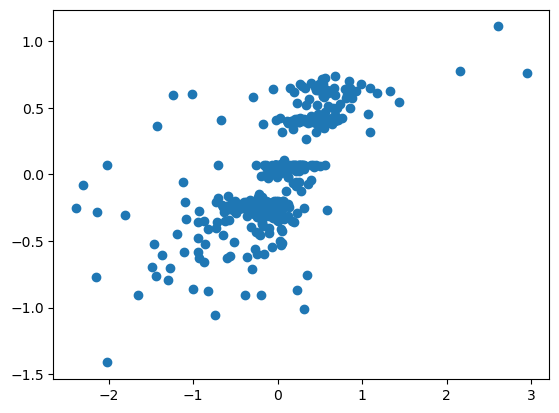

In [102]:
plt.scatter(y_test, grid_search.predict(X_test))

In [104]:
np.mean((y_test-grid_search.predict(X_test))**2)

0.177339175555611

In [106]:
xgb.plot_importance(model_xgb)

NotFittedError: need to call fit or load_model beforehand

In [115]:
RF = RandomForestRegressor()

paramgrid = {
             'n_estimators': [20, 100, 150, 250, 300, 500],
             'criterion': ['squared_error', 'absolute_error'],
             'max_features': ['sqrt', 'log2'],
             'max_depth': [3, 5, 10, 15, 25],
             }

G_CV = GridSearchCV(RF, param_grid=paramgrid, scoring='explained_variance', n_jobs=-1, cv=5)
G_CV.fit(X_train, y_train)
print(f"Best parameters: {G_CV.best_params_}")
print(f"Best Score: {G_CV.best_score_}")

c:\Users\Gavin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best parameters: {'ccp_alpha': 0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score: 0.5142399138501611


In [116]:
{0, 1, 1, 2}

{0, 1, 2}